# Replication code for Efficient Concentration with Gaussian Approximation

## Set up environment

In [1]:
!pip install ttictoc

%load_ext autoreload
%autoreload 2
import numpy as np
from math import pi, sqrt, exp, log, asin, acos, inf, factorial, ceil
import math
from scipy.integrate import quad
from numpy.polynomial.hermite import hermval
from scipy.optimize import minimize_scalar
from scipy.stats import norm, kstwo, ksone, binom
from scipy.special import gammaln, hyp2f1, erfi, gammaincc, gamma, comb
from ssl import HAS_ALPN
from bisect import bisect_left
from scipy.optimize import bisect
from ttictoc import tic,toc
from scipy.stats import poisson
import os
from scipy.special import comb
import warnings
from sympy.functions.combinatorial.numbers import stirling,binomial

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import ticker
plt.rcParams['text.usetex'] = True
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import seaborn as sns
import pandas as pd

from functools import partial
import pickle

if True:
    from google.colab import drive
    drive.mount('/content/drive')
    work_dir = "/content/drive/MyDrive/Colab Notebooks/gauss_conv"
    os.makedirs(work_dir,exist_ok=True)
    os.chdir(work_dir)

Mounted at /content/drive


## Helper functions, precomputation, and mathematical constants

In [2]:
#
# Mathematical constants
#
euler = math.e
rt_2_pi = sqrt(2*pi)
rt_pi = sqrt(pi)
half_pi = pi/2
rt_2 = sqrt(2)

#
# Precompute norms of Hermite polynomials
#
def compute_hermite_norm(n, p):
    """Compute the p-th norm of the n-th Hermite polynomial."""
    two_to_minus_n_over_2 = 2**(-n/2)
    list_arg = [0]*n + [1]
    def integrand(x):
        # This evaluates the n-th Hermite polynomial at x
        Hn_x = two_to_minus_n_over_2 * hermval(x/rt_2, list_arg)
        return np.abs(Hn_x)**p * exp(-x**2/2)/rt_2_pi
    integral, _ = quad(integrand, -np.inf, np.inf)
    return integral**(1/p)

def compute_norms_array(k, ps):
    """Return a 2D array with dimensions (k, len(ps)).
    Each entry (i,j) is the p-th norm of the i+2-nd Hermite polynomial for
    p=ps[j]."""
    norms_array = np.empty((k, len(ps)))

    for n in range(k):
        for j, p in enumerate(ps):
            norms_array[n, j] = compute_hermite_norm(n+2, p)
    return norms_array

# Precompute norms of 2nd through k+1-st Hermite polynomials
k = 11
ps = [2,3,4,5,6,7]
H_norm = compute_norms_array(k, ps)

#
# Helper functions
#
def savefig(fig, file_name, fig_dir="figs"):
    """Saves figure into specified file inside of fig_dir inside"""
    os.makedirs(fig_dir, exist_ok=True)
    # Trim whitespace around the image
    fig.savefig(os.path.join(fig_dir, file_name),bbox_inches='tight',
                pad_inches = 0.05)

def deviation_bound(sig, R=1):
    """Returns almost sure bound on |W - EW| when W in [0,R] with
    Var(W) = sig^2"""
    # Source: Austern and Mackey,
    # "Efficient Concentration with Gaussian Approximation"
    return 0.5*(R+sqrt(R**2-4*sig**2))

def binom_moment(mom=1,n=1,prob=0.5,stirlings=None,binomials=None):
    """Returns the uncentered mom-th moment of a binomial distribution with
    count n and success probability prob

    Args:
      mom - integer moment >= 1
      n - integer count parameter >= 1
      prob - success probability in [0,1]
      stirlings - If not None, this dictionary, indexed by k, will be
        queried for precomputed values before computing any stirling(mom,k)
        values; if not present, values will be added to this dictionary
      binomials - If not None, this dictionary, indexed by k, will be queried
        for precomputed values before computing any binomial(n,k) values;
        if not present, values will be added to this dictionary
    """
    # Initialize empty dictionaries if necessary
    if stirlings is None:
        stirlings = {}
    if binomials is None:
        binomials = {}
    moment = 0.
    factorial = 1
    for k in range(mom+1):
        # Get needed stirling and binomial number
        # Transform sympy.core.numbers.Float into float
        if k not in stirlings:
            stirlings[k] = float(stirling(mom,k))
        if k not in binomials:
            binomials[k] = float(binomial(n,k))
        moment += binomials[k]*factorial*stirlings[k]*prob**k
        # Update factorial
        factorial *= (k+1)
    return moment

#
# Standard tail bounds
#
norm_sf = norm.sf
def asymptotic_tail(t, sig=1, two_sided=True):
    """Returns P(|G| >= t) (two-sided) or P(G >= t) (one-sided) for
    G normally distributed with mean zero and variance sig^2"""
    delta = norm_sf(t/sig)
    if two_sided: delta *= 2
    return delta

def hoeffding_tail(t, R=1, two_sided=True):
    """Returns Hoeffding upper bound on P(|S| > t) or P(S > t)
    for any sum S = sqrt(n) (1/n) sum_{i=1}^n W_i - EW_i
    with each independent and identically distributed W_i in [0, R]."""
    # Source: Theorem 1 (2.3) of Hoeffding, Wassily (1963).
    # "Probability inequalities for sums of bounded random variables"
    delta = exp( - ((t/R)**2) *2 )
    if two_sided: delta *= 2
    return delta

def bernstein_tail(t, n, sig=1, R=1, two_sided=True):
    """Returns Bernstein upper bound on P(|S| > t) or P(S > t)
    for any sum S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i] with each
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2."""
    # Each |W_i - E[W_i]| <= R_s almost surely
    R_s = deviation_bound(sig, R)
    # Source: Cor. 2.11 of Boucheron, Lugosi, and Massart.
    # "Concentration Inequalities A Nonasymptotic Theory of Independence"
    delta = exp( - (t**2) / 2 / ((sig ** 2) + R_s * t / 3 / sqrt(n)) )
    if two_sided: delta *= 2
    return delta

def berry_esseen_penalty(n, sig=1, R=1, two_sided=True):
    """Returns Berry-Esseen two-sided or one-sided bound on the uniform distance
    between the Normal(0, sig^2) distribution function and the distribution
    function of any sum S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i] with each
    independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2."""
    # The Berry-Esseen penalty is in terms of the ratio E[|W_1 - EW_1|^3]/sig^3
    # <= any almost sure bound Rstilde on the deviation |W_1 - EW_1|/sig
    Rstilde = deviation_bound(sig, R)/sig

    # Source: Shevtsova, Irina (2011). "On the absolute constants in the
    # Berry Esseen type inequalities for identically distributed summands"
    penalty = min(.3328 * ( Rstilde + .429 ),
                  .33554 * ( Rstilde + .415 )) / sqrt(n)
    return 2*penalty if two_sided else penalty

def berry_esseen_tail(t, n, sig=1, R=1, two_sided=True):
    """Returns Berry-Esseen upper bound on P(|S| > t) or P(S > t)
    for any sum S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i]
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2."""
    return (asymptotic_tail(t, sig=sig, two_sided=two_sided) +
            berry_esseen_penalty(n, sig=sig, R=R, two_sided=two_sided))

def nonuniform_berry_esseen_penalty(n, sig=1, R=1, two_sided=True):
    """Returns coefficient of the non-uniform Berry-Esseen two-sided or
    one-sided bound on the uniform distance between the Normal(0, sig^2)
    distribution function and the distribution function of any sum
    S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i]
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2."""
    # The Berry-Esseen penalty is in terms of the ratio E[|W_1 - EW_1|^3]/sig^3
    # <= any almost sure bound Rstilde on the deviation |W_1 - EW_1|/sig
    Rstilde = deviation_bound(sig, R)/sig

    # Source: p. 54 of Shevtsova, Irina (2017). "On the absolute constants in
    # Nagaev–Bikelis-type inequalities."
    penalty = min(Rstilde * 17.36, Rstilde * 15.70 + 0.646) / sqrt(n)
    return 2*penalty if two_sided else penalty

def nonuniform_berry_esseen_tail(t, n, sig=1, R=1, two_sided=True):
    """Returns non-uniform Berry-Esseen upper bound on P(|S| > t) or P(S > t)
    for any sum S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i]
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2."""
    # The Berry-Esseen penalty is in terms of the ratio E[|W_1 - EW_1|^3]/sig^3
    # <= any almost sure bound Rstilde on the deviation |W_1 - EW_1|/sig
    Rstilde = deviation_bound(sig, R)/sig
    # Source: p. 54 of Shevtsova, Irina (2017). "On the absolute constants in
    # Nagaev–Bikelis-type inequalities."
    return (asymptotic_tail(t, sig=sig, two_sided=two_sided) +
            nonuniform_berry_esseen_penalty(n,sig=sig,R=R,two_sided=two_sided)
            / (1+abs(t/sig))**3)

def unidentical_berry_esseen_tail(t, n, sig=1, third=1, two_sided=True):
    """Returns unidentical Berry-Esseen upper bound on P(|S| > t) or P(S > t)
    for any sum S = sqrt(n) (1/n) sum_{i=1}^n Y_i
    with independent Y_i satisfying E[Y_i] = 0, (1/n) sum_i Var(Y_i) >= sig^2,
    and (1/n) sum_i E|Y_i|^3 <= third
    """
    # Source: Thm. 1 of Shevtsova, Irina (2012). "An Improvement of Convergence
    # Rate Estimates in the Lyapunov Theorem."
    delta = (asymptotic_tail(t, sig=sig, two_sided=False) +
             .56 * third / (sig ** 3) / sqrt(n))
    if two_sided: delta *= 2
    return delta

def unidentical_bernstein_tail(t, n, sig=1, R=1, two_sided=True):
    """Returns Bernstein upper bound on P(|S| > t) or P(S > t)
    for any sum S = sqrt(n) (1/n) sum_{i=1}^n Y_i
    with independent Y_i satisfying E[Y_i] = 0, (1/n) sum_i Var(Y_i) <= sig^2,
    and |Y_i| <= R almost surely."""
    # Source: Cor. 2.11 of Boucheron, Lugosi, and Massart.
    # "Concentration Inequalities A Nonasymptotic Theory of Independence"
    delta = exp( - (t**2) / 2 / ((sig ** 2) + R * t / 3 / sqrt(n)) )
    if two_sided: delta *= 2
    return delta


#
# Standard quantile bounds
#
norm_ppf = norm.ppf
def asymptotic_quantile(delta, sig=1, two_sided=True):
    """Returns Normal(0, sig^2) two-sided (1-delta/2) or one-sided (1-delta)
    quantile"""
    return sig * norm_ppf(min(1,(1-delta/2) if two_sided else (1-delta)))

def hoeffding_quantile(delta, R=1, two_sided=True):
    """Returns Hoeffding two-sided (1-delta/2) or one-sided (1-delta) quantile
    bound for any sum S = sqrt(n) (1/n) sum_{i=1}^n W_i - EW_i
    with each independent and identically distributed W_i in [0, R]."""
    # Source: Theorem 1 (2.3) of Hoeffding, Wassily (1963).
    # "Probability inequalities for sums of bounded random variables"
    log_delta_term = log(2/delta) if two_sided else log(1/delta)
    return R * sqrt(log_delta_term/2)

def bernstein_quantile(delta, n, sig=1, R=1, two_sided=True):
    """Returns Bernstein two-sided (1-delta/2) or one-sided (1-delta) quantile
    bound for any sum S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i] with each
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2."""
    # Each |W_i - E[W_i]| <= R_s almost surely
    R_s = deviation_bound(sig, R)
    # Source: Theorem 2.10 of Boucheron, Lugosi, and Massart.
    # "Concentration Inequalities A Nonasymptotic Theory of Independence"
    log_delta_term = log(2/delta) if two_sided else log(1/delta)
    return (R_s/3 * log_delta_term / sqrt(n) ) + sig * sqrt(2 * log_delta_term)

def berry_esseen_quantile(delta, n, sig=1, R=1, two_sided=True):
    """Returns Berry-Esseen two-sided (1-delta/2) or one-sided (1-delta)
    quantile bound for any sum S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i]
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2."""
    return asymptotic_quantile(
        max(0, delta -
            berry_esseen_penalty(n, sig=sig, R=R, two_sided=two_sided)),
        sig=sig, two_sided=two_sided)

def berry_esseen_penalty_rw(n, sig=1, R=1, two_sided=True):
    """Returns Berry-Esseen two-sided or one-sided bound employed by Romano
    and Wolf on the uniform distance between the standard normal distribution
    function and the distribution function of any sum
    sqrt(n) (1/n) sum_{i=1}^n (W_i - E[W_i])/sig with each
    independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2."""
    # The Berry-Esseen penalty is in terms of the ratio E[|W_1 - EW_1|^3]/sig^3
    # <= R/sig
    R_over_sig = R/sig
    # Source: Shevtsova, Irina (2011). "On the absolute constants in the
    # Berry Esseen type inequalities for identically distributed summands"
    penalty = min(.3328 * ( R_over_sig + .429 ),
                  .33554 * ( R_over_sig + .415 )) / sqrt(n)
    return 2*penalty if two_sided else penalty

def berry_esseen_quantile_rw(delta, n, sig=1, R=1, two_sided=True):
    """Returns Berry-Esseen two-sided (1-delta/2) or one-sided (1-delta)
    quantile bound employed by Romano and Wolf for any sum
    S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i]
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2."""
    return asymptotic_quantile(
        max(0, delta -
            berry_esseen_penalty_rw(n, sig=sig, R=R, two_sided=two_sided)),
        sig=sig, two_sided=two_sided)

def nonuniform_berry_esseen_quantile(delta, n,sig=1,R=1,two_sided=True):
    """Returns non-uniform Berry-Esseen two-sided (1-delta/2) or one-sided
    (1-delta) quantile bound for any sum
    S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i]
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2."""
    # Find quantile bound by inverting tail bound
    def invert_nonuniform_berry_esseen_tail(delta, tmin, tmax):
        """Returns value of t in [tmin, tmax] for which
        nonuniform_berry_esseen_tail(t,n,sig,R) = delta"""
        g = lambda t: (
            nonuniform_berry_esseen_tail(t,n,sig=sig,R=R,two_sided=two_sided)
            - delta)
        # Use the bisect method to find the root of g within the interval
        # [tmin, tmax]
        return bisect(g, tmin, tmax)

    # Quantile bound will be no smaller than asymptotic quantile
    tmin=asymptotic_quantile(delta, sig=sig, two_sided=two_sided)
    # Since P(G >= t) = P(Z >= t/sig) <= P(|Z|+1 >= 1+t/sig)
    # <= E[(|Z|+1)^3] / (1+|t|/sig)^3 = (4+5*sqrt(2/pi)) / (1+|t|/sig)^3
    # for G ~ N(0, sig^2) and Z ~ N(0, 1), quantile bound will be no larger
    # than the following
    gsn_coeff = 4+5*sqrt(2/pi)
    coeff = (nonuniform_berry_esseen_penalty(n,sig=sig,R=R,two_sided=two_sided)
        + gsn_coeff)
    tmax= sig * ((coeff/delta)**(1./3) - 1)
    return invert_nonuniform_berry_esseen_tail(delta, tmin, tmax)

def emp_bernstein_quantile(delta, n, sighat=1, R=1, two_sided=True):
    """Returns empirical Bernstein two-sided (1-delta/2) or one-sided (1-delta)
    quantile bound for any sum S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i]
    with each independent and identically distributed W_i in [0, R] with
    empirical variance sighat^2 = (1/n) sum_i (W_i - (1/n)sum_j W_j)^2."""
    # Source: Thm. 4 of Maurer and Pontil,
    # "Empirical Bernstein Bounds and Sample Variance Penalization"
    # Thm. 4 operates on [0,1] so need to multiply boundedness term by R
    log_delta_term = log(4/delta) if two_sided else log(2/delta)
    return ( (7*R/3 * log_delta_term * sqrt(n) / (n-1) ) +
            sighat * sqrt( 2 * log_delta_term * n/(n-1) ) )

## Wasserstein distance bound

In [3]:
def gsn_wass(n, p, sig=1, R=1, Kp=6, verbose=False):
    """Bound on Lp Wasserstein distance between an iid sum and a Gaussian
    with matching mean and variance

    Returns bound on the Lp Wasserstein distance between a zero mean Gaussian
    distribution with variance sig^2 and any sum
    S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i]
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2.

    Args:
      n - Number of datapoints W_i
      p - Wasserstein distance power >= 1
      sig - Standard deviation parameter
      R - Boundedness parameter
      Kp - Positive integer truncation parameter in the bound of Austern and
        Mackey (can typically be left at its default value)
      verbose - If True will display minimize_scalar convergence messages
    """
    if sig <= 0: return 0
    if p == 1:
        return deviation_bound(sig,R=R) / sqrt(n)

    p_minus_1 = p-1
    sqrt_p_minus_1 = sqrt(p_minus_1)
    Rtilde = R / sig
    Rtilde_sqd = Rtilde * Rtilde
    Rtilde_to_2_over_p = Rtilde**(2/p)
    Rsmaller=Rtilde-0.5*(Rtilde-sqrt(Rtilde**2-4))
    Rsmaller_sqd = Rsmaller * Rsmaller
    Rsmaller_sqd_minus_1 = Rsmaller_sqd - 1
    Rsmaller_to_2_over_p=Rsmaller**(2/p)
    p_plus_2 = p+2
    one_over_p = 1/p
    n_to_1_over_p = n ** one_over_p
    sqrt_n = sqrt(n)
    two_sqrt_n = 2 * sqrt_n

    A = sqrt(p_plus_2 * euler / 2) * ( (2 * euler) ** one_over_p )
    Atilde = p_plus_2 * n_to_1_over_p / (two_sqrt_n * Rtilde_to_2_over_p)
    Astar = Rtilde_to_2_over_p * Atilde
    U = (Atilde *Rtilde+ A)
    tildeU = (2**one_over_p*Rtilde*Atilde+rt_2*A)

    ceil_p = ceil(p)
    two_over_Rtilde_sqd = 2/Rtilde_sqd

    # Prepare dictionaries to store binomial coefficients for
    # computing binomial moments
    binomials = {}
    if True:
        bin_mom = binom_moment(mom=ceil_p, n=n, prob=two_over_Rtilde_sqd,
                              binomials=binomials)
    else:
        bin_mom = binom.moment(ceil_p, n, two_over_Rtilde_sqd)
    moment_bin = Rtilde_sqd / n * bin_mom**(1/ceil_p)

    # Prepare dictionaries to store Stirling numbers for
    # computing binomial moments
    stirlings = {}
    ceil_p_over_2 = ceil(p/2)
    if True:
        bin_mom = binom_moment(mom=ceil_p_over_2, n=n, prob=two_over_Rtilde_sqd,
                               stirlings=stirlings, binomials=binomials)
    else:
        bin_mom = binom.moment(ceil_p_over_2, n, two_over_Rtilde_sqd)
    moment_bin_symm = sqrt(Rtilde_sqd / n * bin_mom**(1/ceil_p_over_2))

    #for $k=2$
    if Rsmaller>1:
        if True:
            bin_mom = binom_moment(mom=ceil_p_over_2, n=n,
                                  prob=2*Rsmaller_sqd_minus_1/Rsmaller_sqd**2,
                                  stirlings=stirlings, binomials=binomials)
        else:
            bin_mom = binom.moment(ceil_p_over_2, n,
                                  2*Rsmaller_sqd_minus_1/Rsmaller_sqd**2)
        moment_bin_symm_2=(Rsmaller_sqd / n * sqrt(bin_mom**(1/ceil_p_over_2)))

    std_gsn_p_norm = rt_2 * exp( (gammaln((p+1)/2) - log(pi)/2) / p )

    term2p=max(Rsmaller_sqd_minus_1**(1-one_over_p),
        ((Rsmaller_sqd_minus_1**p + Rsmaller_sqd_minus_1)/Rsmaller_sqd)**one_over_p)
    # the different terms candidate for 1/2\|\sum_i X_i^2-1\|_p
    common3a = min(sqrt_p_minus_1,std_gsn_p_norm )
    r3a = common3a * (term2p*Astar + sqrt(Rsmaller_sqd_minus_1) * A ) / two_sqrt_n
    c3a = common3a * sqrt_p_minus_1 * term2p  / two_sqrt_n

    gamma_factor = (gamma((p+1)/2)/rt_pi)**one_over_p*rt_2
    d3a = (gamma_factor*Rsmaller**(2*(1-2/p))*(Rsmaller_sqd_minus_1)**one_over_p /
           two_sqrt_n)

    if p>=4 and Rsmaller>1:
        d3a=min(2**(-one_over_p)*moment_bin_symm_2*gamma_factor/two_sqrt_n, d3a)

    c3a=min(d3a,c3a)

    sqrt_e_over_3 = sqrt(euler/3)

    c_M = Rtilde_sqd / n


    # Baseline upper bound based on the triangle inequality:
    # E[|S-G|^p]^{1/p} <= E[|S|^p]^{1/p} + E[|G|^p]^{1/p}
    # <= sqrt(p-1) E[|Y_1|^p]^{1/p} + E[|G|^p]^{1/p}
    # (by the Marcinkiewicz-Zygmund inequality)
    # <= sqrt(p-1) E[ R^{p-2} |Y_1|^2]^{1/p} + E[|G|^p]^{1/p}
    # <= sqrt(p-1) R * (sig/R)^{2/p} + E[|G|^p]^{1/p}
    # = sqrt(p-1) R / Rtilde^{2/p} + E[|G|^p]^{1/p}
    # triangle_bound = E[|S-G|^p]^{1/p} / sig
    triangle_bound = (sqrt_p_minus_1 * Rtilde / Rtilde_to_2_over_p
                      + std_gsn_p_norm)
    if verbose:
        print(f"triangle bound: {triangle_bound}")

    # Note that we must have k > c_M to ensure M is well defined and finite.
    # For an upper bound on k, choose a value larger than the
    # analytically-derived choice (2/(p+2)) from Austern and Mackey
    k_max = 1

    if verbose:
        print(f"k range: ({c_M}, {k_max}]")

    # If the bound range is empty, return triangle bound
    if k_max <= c_M:
        return sig*triangle_bound

    # Define collection of bounds on p-Wasserstein distance parameterized by k
    one_over_n = 1/n
    Rtilde_over_sqrt_n = Rtilde / sqrt_n
    # Precompute constants needed for bound
    # fl_coeff
    fl_coeff = p_minus_1*Rtilde_sqd/2
    # f_coeff: (B_{p,n}/2) /sqrt(n)
    f_coeff = moment_bin/sqrt_n/2
    Kp_fourth_root = Kp**(1/4)
    two_Kp_plus_one = 2*Kp+1
    f_Kp_factor = Kp_fourth_root/(2*(Kp+1)*sqrt(two_Kp_plus_one))
    # f3_coeff
    Cp = gamma_factor*Rtilde**(1-2/p)*2**(1/p)
    if p>=4:
        Cp = min(moment_bin_symm*gamma_factor,Cp)
    factor = min(Cp,tildeU)
    f3_coeff = factor * one_over_n /2
    f3_Kp_factor = Kp_fourth_root/two_Kp_plus_one
    # g58_coeff
    pi_exp_factor = (pi)**(1/4)*(exp(19/300))
    renorm = pi_exp_factor * 2 * f_Kp_factor * sqrt_p_minus_1
    g58_coeff = f_coeff*renorm/2
    # g68_coeff
    g68_coeff = f3_coeff * pi_exp_factor * f3_Kp_factor
    def bound(k):
        # Bound is only finite for k > c_M
        if k <= c_M:
            return inf

        M_sqd = 1 - c_M / k
        M = sqrt(M_sqd)
        r2_bound = std_gsn_p_norm*(half_pi-math.asin(M))

        sqrt_k = sqrt(k)
        term_3 = 1 - Rtilde_over_sqrt_n / sqrt_k
        r3_bound = r3a * term_3
        c3_bound = c3a * term_3

        C = k * p_minus_1
        two_C = 2*C
        Rtilde_sqd_over_k = Rtilde_sqd/k
        k_over_Rtilde_sqd = k/Rtilde_sqd

        #bounding for the even terms
        def f(i,x):
            """Function defining the summand
            (Rtilde^{2i}) *
              (||H_{2i+1}||_p/(2i+2)!
               - 2^{-i} exp(19/300)pi^{1/4} sqrt(p-1)^{2i+1}/
               (2(K_p +1)sqrt(2K_p+1) i! ) * (1/x-1/n)^i/sqrt(x)."""
            # Note: For greater efficiency, delta could be precomputed for each
            # i,p value, in the same way H_norm is precomputed
            if p<7:
                delta=H_norm[2*i-1,p-2]/(factorial(2*i+2))
            else:
                delta=sqrt_p_minus_1**(2*i+1)/((2*i+2)*sqrt(factorial(2*i+1)))
            delta -= (f_Kp_factor*2**(-i)*pi_exp_factor*p_minus_1**(i+1/2)
                /factorial(i))
            v=(Rtilde_sqd)**i

            uu=((1/x-1/n)**i)*delta*v/sqrt(x)
            return uu

        def g5(x):
            """Function to sum the values of f for i between 1 and K[-1"""
            total = 0
            for i in range(1, Kp):
                total += f(i,x)
            return total

        int_g5 = quad(g5, Rtilde_sqd_over_k, n)[0] * f_coeff

        def g58(x):
            """This corresponds to the integral for terms k\ge 4 that are even.
            This is computed by upper bounding the Hermite polynomial and lower
            bounding sqrt(k!) and relating the terms to an exponential."""
            fl= fl_coeff*(x-one_over_n)
            return (exp(fl)-1)/(x**(3/2))
        int_g58 = quad(g58, one_over_n, k_over_Rtilde_sqd)[0] * g58_coeff
        r4_bound = int_g5+int_g58
        c4_bound = r4_bound

        #bounding for the odd terms
        def f3(i,x):
            """Function defining the summand for odd K_p\le k\ge 3."""
            v=(Rtilde_sqd)**i
            if p<7:
                delta=H_norm[2*i-2,p-2]/(factorial(2*i+1))
            else:
                delta=sqrt_p_minus_1**(2*i)/((2*i+1)*sqrt(factorial(2*i)))
            delta -=f3_Kp_factor*2**(-i)*pi_exp_factor*p_minus_1**i/factorial(i)
            uu=(1/x-one_over_n)**(i-1/2)*delta*v/sqrt(x)
            return uu

        def g6(x):
            """Function to sum the values of f3 for i between 1 and Kp-1"""
            total = 0
            for i in range(1, Kp):
                total += f3(i,x)
            return total

        int_g6 = quad(g6, Rtilde_sqd_over_k, n)[0] * f3_coeff

        def g68(x):
            """This corresponds to the integral for odd terms k\ge 3.
            This is computed by upper bounding the Hermite polynomial and
            lower bounding sqrt(k!) and relating the terms to an exponential."""
            fl = fl_coeff*(x-one_over_n)
            return (exp(fl)-1)/(x**1.5*sqrt(x-one_over_n))
        int_g68 = quad(g68, one_over_n, k_over_Rtilde_sqd)[0] * g68_coeff
        r5_bound = int_g6+int_g68
        c5_bound = r5_bound

        #multiplicative term
        if p==2:
            scaling_term=1
        else:
            scaling_term=1/M

        return (scaling_term*(r2_bound
                +
                min(c3_bound, r3_bound)
                +
                min(c4_bound, r4_bound)
                +
                min(c5_bound, r5_bound)))

    if verbose:
        # Plot log bound as a function of k
        ks = np.geomspace(c_M, k_max)
        plt.plot(ks, [log(sig*bound(k)) for k in ks])
        plt.ylabel(r'Log bound on p-Wasserstein distance')
        plt.xlabel(r'$k$')
        plt.title(f'n = {n}, p = {p}, sig = {sig}, R = {R}')
        plt.tight_layout()
        plt.show()

    # Find minimal value of bound(k) over [c_M, k_max]
    minimum = minimize_scalar(bound, bounds=[c_M, k_max],
                              method='bounded', options={"disp":verbose})
    if verbose:
        print(sig*minimum.fun)
    val=sig*min(triangle_bound, minimum.fun)
    return val

## Zero bias tail bounds


In [5]:
def Sprime_tail(t, n, sig=1, R=1, two_sided=True, verbose=False):
    """Tail bound for an auxiliary sum S'

    Returns delta such that P(|S'| > t) <= delta (if two_sided) or
    P(S' > t) <= delta (otherwise) for any sum
    S' = sqrt(n) (1/n) [sum_{i=1}^{n-1} (W_i - E[W_i]) + Y_{n}']
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2, and
    Y_{n}' = Y_{n}^* + U(Y_{n} - Y_{n}^*) for independent
    (U, Y_n^*) with U ~ Unif([0,1]) and Y_n^* having the
    zero-bias distribution of (W_n-EW_n).

    Specifically, returns
      delta = min(1, delta_hoeff((u)_+), delta_bern((u)_+), delta_be(u))
    for u = t-R_s/(4sqrt(n)) and R_s = (R+sqrt(R^2-4sig^2))/2
    where delta_{hoeff,bern,be} are respectively Hoeffding, Bernstein, and
    Berry-Esseen tail bounds for unidentically distributed variable sums.

    Args:
      t - Positive number
      n - Number of datapoints X_i
      sig - Standard deviation parameter; Var(X_i) = sig^2/n
      R - Boundedness parameter; |X_i| <= sqrt(n) R
      two_sided - return two-sided tail bounds?
      verbose - If True will print diagnostic messages
    """
    sqrt_n = sqrt(n)
    sig_sqd = sig**2
    R_sqd = R**2
    R_s = (R+sqrt(R_sqd-4*sig_sqd))/2
    u = t-R_s/4/sqrt_n
    # Upper bound for average variance
    R_s_sqd = R_s**2
    v_up_sqd = sig_sqd+(R_s_sqd-6*sig_sqd)/(9*n)
    # Square root of lower bound for average variance
    v_low = sig*sqrt(1-89./144./n)
    R_s_mod = (R+sqrt(R_sqd-220*sig_sqd/144))/2
    delta_be = unidentical_berry_esseen_tail(
        u, n,
        sig=v_low,
        third=R_s*v_up_sqd+min(R_s/4,R_s_mod-R_s)*(sig_sqd+R_s_sqd/3)/3/n,
        two_sided=two_sided)
    if u <= 0:
        return min(1, delta_be)
    delta_hoeff = hoeffding_tail(u, R=R, two_sided=two_sided)
    delta_bern = unidentical_bernstein_tail(
        u, n, sig=sqrt(v_up_sqd), R=R_s,
        two_sided=two_sided)
    if verbose:
        print(f"be={delta_be}, hoeff={delta_hoeff}, bern={delta_bern}")
    return min(1, delta_hoeff, delta_bern, delta_be)

def zero_tail_iid(t, n, sig=1, R=1, two_sided=True, verbose=False):
    """Zero bias tail bound for an iid sum that exploits specific iid structure

    Returns delta such that P(|S| > t) <= delta (if two_sided) or
    P(S > t) <= delta (otherwise) for any sum
    S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i]
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2.

    Specifically, returns for u = (sqrt(n)/sqrt(n+1))(t-R_s/sqrt(n))_+/sig,
      delta = min(1, delta_2)
    where
      delta_2 = (\sig \sqrt{n+1})/(\sig \sqrt{n+1}+R \diff[u]) \Phi^c(u)
        + (R)/(\sig \sqrt{n+1}+R\,\diff[u])
        x inf_{lam in [0,1]} [h_u(\lam u) + (h_u(u) - h_u(\lam u))
        x delta_{aux,2}(lam sig u sqrt(n)/sqrt(n+1))],
      delta_{aux,2}(t) = Sprime_tail(t, n+1, sig, R),
      h_u(w) = (w + (1+w^2) sqrt(2pi)exp(w^2/2)Phi(w)) Phi^c(u), and
      diff[u] = h_u(u)-(2/(u+sqrt(u^2+8/pi)-8u/(pi(u+sqrt(u^2+8/pi))^2))) Phi(u)

    Args:
      t - Positive number
      n - Number of datapoints W_i
      sig - Standard deviation parameter; Var(W_i) = sig^2
      R - Boundedness parameter
      two_sided - return two-sided tail bounds?
      verbose - If True will display diagnostic messages
    """
    R_s=0.5*(R+sqrt(R**2-4*sig**2))
    sqrt_n = sqrt(n)
    sqrt_n_plus_1 = sqrt(n+1)
    sqrt_n_ratio = sqrt_n / sqrt_n_plus_1
    u = sqrt_n_ratio * (t-R_s/sqrt_n)/sig

    # Bound reduces to 1 for non-positive u
    if u <= 0:
        return 1.

    # Helper function
    log_Phic_u = norm.logsf(u)
    Phic_u = exp(log_Phic_u)
    norm_cdf = norm.cdf
    def h_u(w):
        w_sqd = w**2
        return (w * Phic_u + (1+w_sqd) * rt_2_pi * norm_cdf(w) *
                exp(log_Phic_u + w_sqd/2))

    # Define collection of bounds parameterized by lam in [0,1]
    h_u_u = h_u(u)
    sig_sqrt_n_ratio = sig * sqrt_n_ratio
    def bound(lam, verbose=verbose):
        lam_u = lam*u
        h_u_lam_u = h_u(lam_u)
        # Compute one-sided bound here and account for two-sidedness at the end
        return (h_u_lam_u + (h_u_u - h_u_lam_u) *
                Sprime_tail(lam_u * sig_sqrt_n_ratio, n+1, sig=sig, R=R,
                            verbose=False, two_sided=False))
    # Find minimal value of bound(lam) over [0,1]
    tic()
    minimum = minimize_scalar(bound, bounds=[0, 1], method='bounded',
                              options={"disp":verbose})
    elapsed = toc()
    if verbose:
        print(f"elapsed: {elapsed}s")
        print(f"minimum={minimum.fun}, lam={minimum.x}\n")
    if False:
        # Plot bound as a function of lam
        lams = np.linspace(0, 1)
        plt.plot(lams, [bound(lam) for lam in lams])
        plt.ylabel(r'Zero-bias lambda term')
        plt.xlabel(r'$\lambda$')
        plt.title(f't = {t}, u ={u}, n = {n}, sig = {sig}, R = {R}')
        plt.tight_layout()
        plt.show()
    # Return complete bound
    sig_sqrt_n_plus_1 = sig * sqrt_n_plus_1
    denom = u + sqrt(u**2 + 8/pi)
    diff_u = h_u_u - (2/denom  - 8*u/(pi * (denom**2))) * (1-Phic_u)
    if verbose:
        print(f'diff_u = {diff_u}, h_u(0) = {h_u(0)}')
    R_diff_u = R * diff_u
    delta = (sig_sqrt_n_plus_1 * Phic_u
             + R * minimum.fun)/(sig_sqrt_n_plus_1 + R_diff_u)
    if two_sided: delta *= 2
    return delta

def zero_tail_general(t, n, sig=1, R=1, two_sided=True, verbose=False):
    """Zero bias tail bound for an iid sum derived from unidentical sum tail
    bound

    Returns delta such that P(|S| > t) <= delta (if two_sided) or
    P(S > t) <= delta (otherwise) for any sum
    S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i]
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2.

    Specifically, returns for u = (t-R/sqrt(n))_+/sig,
      delta = min(1, delta_1)
    where
      delta_1 = (\sig \sqrt{n})/(\sig \sqrt{n}+R \diff[u]) \Phi^c(u)
        + R/(\sig \sqrt{n}+R\,\diff[u])
        x inf_{lam in [0,1]} [h_u(\lam u) +
                              (h_u(u) - h_u(\lam u)) delta_{aux,1}(lam sig u)]
      delta_{aux,1}(t) = Sprime_tail(t, n, sig, R)

    Args:
      t - Positive number
      n - Number of datapoints W_i
      sig - Standard deviation parameter; Var(W_i) = sig^2
      R - Boundedness parameter
      two_sided - return two-sided tail bounds?
      verbose - If True will display diagnostic messages
    """

    sqrt_n = sqrt(n)
    u = (t-R/sqrt_n)/sig

    # Bound reduces to 1 for non-positive u
    if u <= 0:
        return 1.

    # Helper function
    log_Phic_u = norm.logsf(u)
    Phic_u = exp(log_Phic_u)
    norm_cdf = norm.cdf
    def h_u(w):
        w_sqd = w**2
        return (w * Phic_u +
                (1+w_sqd) * rt_2_pi * norm_cdf(w) * exp(log_Phic_u + w_sqd/2))

    # Define collection of bounds parameterized by lam in [0,1]
    h_u_u = h_u(u)
    def bound(lam, verbose=verbose):
        lam_u = lam*u
        h_u_lam_u = h_u(lam_u)
        # Compute one-sided bound here and account for two-sidedness at the end
        return (h_u_lam_u + (h_u_u - h_u_lam_u) *
                Sprime_tail(lam_u * sig, n, sig=sig, R=R, verbose=False,
                            two_sided=False))
    # Find minimal value of bound(lam) over [0,1]
    tic()
    minimum = minimize_scalar(bound, bounds=[0, 1], method='bounded',
                              options={"disp":verbose})
    elapsed = toc()
    if verbose:
        print(f"elapsed: {elapsed}s")
        print(f"minimum={minimum.fun}, lam={minimum.x}\n")
    if False:
        # Plot bound as a function of lam
        lams = np.linspace(0, 1)
        plt.plot(lams, [bound(lam) for lam in lams])
        plt.ylabel(r'Zero-bias lambda term')
        plt.xlabel(r'$\lambda$')
        plt.title(f't = {t}, u ={u}, n = {n}, sig = {sig}, R = {R}')
        plt.tight_layout()
        plt.show()
    # Return complete bound
    sig_sqrt_n = sig * sqrt_n
    denom = u + sqrt(u**2 + 8/pi)
    diff_u = h_u_u - (2/denom  - 8*u/(pi * (denom**2))) * (1-Phic_u)
    if verbose:
        print(f'diff_u = {diff_u}, h_u(0) = {h_u(0)}')
    R_diff_u = R * diff_u
    delta = (sig_sqrt_n/(sig_sqrt_n +R_diff_u) * Phic_u
        + R/(sig_sqrt_n + R_diff_u) * minimum.fun)
    if two_sided: delta *= 2
    return delta

def zero_tail(t, n, sig=1, R=1, two_sided=True, verbose=False):
    """Zero bias tail bound for an iid sum

    Returns minimum of zero_tail_iid and zero_tail_general.

    Args:
      t - Positive number
      n - Number of datapoints W_i
      sig - Standard deviation parameter; Var(W_i) = sig^2
      R - Boundedness parameter
      two_sided - return two-sided tail bounds?
      verbose - If True will display diagnostic messages
    """
    return min(zero_tail_iid(t, n, sig=sig, R=R, two_sided=two_sided,
                             verbose=verbose),
               zero_tail_general(t, n, sig=sig, R=R, two_sided=two_sided,
                             verbose=verbose))

## Efficient tail bound

In [8]:
def tail_bound(t, n, p=None, sig=1, R=1, two_sided=True, verbose=False, Ws=None):
    """Tail bound for an iid sum based on gsn_wass

    Returns delta such that P(|S| > t) <= delta (if two_sided) or
    P(S > t) <= delta (otherwise) for any sum
    S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i]
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2.

    Specifically, returns, if p is None,
      delta = min(inf_{rho in (0,1), p >= 2} delta_{rho,p}, delta_{Bernstein})
    or, if p is not None,
      delta = min(inf_{rho in (0,1)} delta_{rho,p}, delta_{Bernstein})
    where, if two-sided,
      delta_{rho,p} = CCDF(rho t / sig) + gsn_wass(n, p, sig, R)^p/(t(1-rho))^p,
      CCDF(s) = P(Z >= s) = 1 - CDF(s) for Z a standard Gaussian,
      and delta_{Bernstein} = exp( -(t^2) / 2 / ((sig^2) + R t / 3 / sqrt(n)) ),
    and, if one-sided,
      delta_{rho,p} = CCDF(rho t/sig)+gsn_wass(n, p, sig, R)^p/(1+(t(1-rho))^p)
      and delta_{Bernstein} = 2 exp(-(t^2) / 2 / ((sig^2) + R t / 3 / sqrt(n))).

    Args:
      t - Positive number
      n - Number of datapoints Y_i
      sig - Standard deviation parameter; Var(Y_i) = sig^2
      R - Boundedness parameter
      p - None (to return minimum bound over all p) or integer Wasserstein
        distance power >= 1
      two_sided - return two-sided tail bounds?
      verbose - If True will display minimize_scalar convergence messages
      Ws - If not None, this dictionary, indexed by p, will be queried for
        precomputed values before computing any gsn_wass(n, p, sig, R) values;
        if not present, values will be added to this dictionary
    """

    # Bound reduces to 1 for non-positive t
    if t <= 0:
        return 1.

    if Ws is None:
        # Initialize empty dictionary
        Ws = {}

    # Compute minimum bound over desired range of p values
    if p is None:
        # Consider all p values >= 2
        min_over_p = True
        p_init = 2
    else:
        min_over_p = False
        p_init = p

    # Keep track of the smallest bound encountered while iterating over p
    min_bound = 1.

    # Compute sufficient statistic t/sig
    t_over_sig = t/sig

    # Define collection of bounds parameterized by rho in [0,1]
    def bound(rho, verbose=verbose):
        if rho == 1:
            min_wass_term = 1
            p = None
        else:
            one_minus_rho_times_t = (1-rho)*t
            # Optimize p-Wasserstein component of bound over p
            min_wass_term = 1
            p = p_init
            while True:
                # Look up p-Wasserstein distance
                if p not in Ws:
                    Ws[p] = gsn_wass(n, p, sig=sig, R=R)
                W_ratio = Ws[p] / one_minus_rho_times_t

                W_ratio_to_p = W_ratio ** p
                if (p == 2) and not two_sided:
                    # Use Cantelli's inequality [1 / ( 1 + t^p /(gamma * W)^p )]
                    # for one-sided when p = 2
                    wass_term = W_ratio_to_p / (W_ratio_to_p + 1)
                else:
                    # Otherwise use Chebyshev's inequality
                    wass_term = W_ratio_to_p
                min_wass_term = min(min_wass_term, wass_term)

                # Terminate if only a single p value was requested, if wass_term
                # begins to increase, or if gamma_W_over_t_to_p >= 1 (since all
                # bounds based on larger p will be no smaller)
                if (not min_over_p or (min_wass_term < wass_term) or
                    (W_ratio_to_p >= 1)):
                    break

                # Otherwise, consider the next value of p
                p += 1

        # Compute Gaussian tail probability
        gsn_term = norm.sf(rho * t_over_sig)
        if two_sided:
            gsn_term *= 2
        bound_val = min_wass_term + gsn_term
        if verbose:
            print(f"rho={rho}: bound={bound_val}, wass={min_wass_term}, "
                  f"gsn={gsn_term}, p_last={p}")
        return bound_val

    if verbose:
        # Plot log bound as a function of k
        rho_vals = np.linspace(0, 1)
        plt.plot(rho_vals, [log(bound(rho,verbose=False)) for rho in rho_vals])
        plt.ylabel(r'Log bound on $P(S \geq t)$')
        plt.xlabel(r'$\rho$')
        plt.title(fr't = {t}, n = {n}, p = {p}, $\sigma$ = {sig}, R = {R}')
        plt.tight_layout()
        plt.show()

    # Find minimal value of bound(rho) over [0,1]
    tic()
    minimum = minimize_scalar(bound, bounds=[0, 1], method='bounded',
                              options={"disp":verbose})
    elapsed = toc()
    if verbose:
        print(f"elapsed: {elapsed}s")
    # Compare with baseline tail bounds
    bern_delta = bernstein_tail(t, n, sig=sig, R=R, two_sided=two_sided)
    be_delta = berry_esseen_tail(t, n, sig=sig, R=R, two_sided=two_sided)
    nbe_delta = nonuniform_berry_esseen_tail(t, n, sig=sig, R=R,
                                             two_sided=two_sided)
    hoeff_delta = hoeffding_tail(t, R=R, two_sided=two_sided)
    zero_delta = zero_tail(t, n, sig=sig, R=R, two_sided=two_sided)
    if verbose:
        print(f"minimum={minimum.fun}, rho={minimum.x}, "
              f"bernstein={bern_delta}, BE={be_delta}, NBE={nbe_delta}, "
              f"hoeffding={hoeff_delta}, zero={zero_delta}\n")
    return min(minimum.fun, bern_delta, be_delta, nbe_delta, hoeff_delta,
               zero_delta)

## Efficient quantile bound


In [10]:
def zero_quantile(delta, n, qmax, sig=1, R=1, two_sided=True):
    """Zero bias quantile bound for an iid sum

    Returns minimum of qmax and zero bias quantile q
    s.t. P(|S| > q) <= delta (if two_sided) or P(S > q) <= delta (otherwise)
    for any sum S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i]
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2.

    The zero bias quantile q is computed by inverting zero_tail.

    Args:
      delta - Upper tail probability
      n - Number of datapoints W_i
      qmax - Returns minimum of qmax and zero
      sig - Standard deviation parameter
      R - Boundedness parameter
      two_sided - Provide two-sided quantile bound?
    """
    # if zero_tail(qmax) >= delta, then zero bias quantile >= qmax
    if zero_tail(qmax,n,sig=sig,R=R,two_sided=two_sided) >= delta:
        return qmax

    # Find quantile bound by inverting tail bound
    def invert_zero_tail(delta, qmin, qmax):
        """Returns value of q in [qmin, qmax] for which
        zero_tail(q,n,sig,R) = delta"""
        g = lambda q: (
            zero_tail(q,n,sig=sig,R=R,two_sided=two_sided)
            - delta)
        # Use the bisect method to find the root of g within the interval
        # [qmin, qmax]
        return bisect(g, qmin, qmax)

    # Quantile bound will be no smaller than asymptotic quantile
    qmin=asymptotic_quantile(delta, sig=sig, two_sided=two_sided)
    return invert_zero_tail(delta, qmin, qmax)

def compute_p_norm(t, p):
    """Returns (2 * int_t^inf |x|^p phi(x) dx)^{1/p} for t >= 0 and
    phi the standard normal pdf"""
    def integrand(x, p):
        return (abs(x) ** p) * norm.pdf(x)
    # Calculate the integral for the region Z >= t
    integral_pos = quad(integrand, t, np.inf, args=(p))[0]

    # Double to account for the region Z <= -t
    p_norm = 2*integral_pos
    return p_norm**(1/p)

def quantile_bound(delta, n, p=None, sig=1, R=1, two_sided=True, verbose=False,
                   Ws=None):
    """Quantile bound for an iid sum

    Returns q s.t. P(|S| > q) <= delta (if two_sided) or P(S > q) <= delta
    (otherwise) for any sum S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i]
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2.

    Specifically, returns, if p is None,
      q = min( inf_{a in (0, delta), p >= 1} q_{a,p}, q_{baseline} )
    or, if p is not None,
      q = min( inf_{a in (0, delta)} q_{a,p}, q_{baseline} )
    where, if not two_sided,
      q_{a,p} = gsn_wass(n, p, sig, R)(1/a - indic{p==2})^{1/p}
              + sig GsnInvCDF(1-(delta-a)),
      GsnInvCDF(s) satisfies P(Z <= GsnInvCDF(s)) = s for Z a standard Gaussian,
    and, if two_sided,
      q_{a,p} = gsn_wass(n, p, sig, R)/a^{1/p} + sig GsnInvCDF(1-(delta-a)/2)
    and q_{baseline} is the best of the corresponding delta Bernstein,
    Berry Esseen, non-uniform Berry Esseen, Hoeffding, and zero bias quantiles.

    Args:
      delta - Upper tail probability
      n - Number of datapoints W_i
      p - None (to return minimum bound over all p) or integer Wasserstein
        distance power >= 1
      sig - Standard deviation parameter
      R - Boundedness parameter
      two_sided - Provide two-sided quantile bound?
      verbose - If True will display minimize_scalar convergence messages
      Ws - If not None, this dictionary, indexed by p, will be queried for
        precomputed values before computing any gsn_wass(n, p, sig, R) values;
        if not present, values will be added to this dictionary
    """
    if sig == 0:
        return 0

    if Ws is None:
        # Initialize empty dictionary
        Ws = {}

    # Compute minimum bound over desired range of p values
    if p is None:
        # Consider all p values >= 1
        min_over_p = True
        p_init = 1
    else:
        min_over_p = False
        p_init = p

    # First, compute the Wasserstein bound
    # min_p (1/delta)**(1/p)* [Ws[p]+\|Z I(Z\ge Phi^{-1}(delta))\|_p]
    wass_q = inf
    one_over_delta = 1/delta
    p = p_init
    asymp_q = asymptotic_quantile(delta,sig=sig)
    while True:
        # Look up the p-Wasserstein distance between sum S and Gaussian with
        # matching mean and variance
        if p not in Ws:
            Ws[p] = gsn_wass(n, p, sig=sig, R=R, verbose=verbose)

        wass_term = (sig*compute_p_norm(asymp_q, p)+Ws[p])*one_over_delta**(1/p)
        wass_q = min(wass_q, wass_term)

        # Terminate if only a single p value was requested or bound for the
        # most recent p was greater than prior bound
        if (not min_over_p or wass_term > wass_q):
            break

        # Otherwise, consider the next value of p
        p += 1

    # Next, define a collection of alternative Wasserstein bounds parameterized
    # by a in (0,delta)
    def bound(a, verbose=verbose):
        # Bound is only finite for a in (0,delta)
        if a <= 0 or a >= delta:
            return inf

        p = p_init
        a_term = 1/a
        min_wass_term = inf
        while True:
            # Look up the p-Wasserstein distance between sum S and Gaussian with
            # matching mean and variance
            if p not in Ws:
                Ws[p] = gsn_wass(n, p, sig=sig, R=R, verbose=verbose)

            if not two_sided and (p == 2):
                # Use Cantelli's inequality
                wass_term = Ws[p] * ((a_term-1) ** (1/p))
            else:
                # Use Chebyshev's inequality
                wass_term = Ws[p] * (a_term ** (1/p))

            min_wass_term = min(min_wass_term, wass_term)
            # Terminate if only a single p value was requested or bound for the
            # most recent p was greater than prior bound
            if (not min_over_p or wass_term > min_wass_term):
                break

            # Otherwise, consider the next value of p
            p += 1

        gsn_term = asymptotic_quantile(delta-a, sig=sig, two_sided=two_sided)

        bound_val = min_wass_term + gsn_term
        if verbose:
            print(f"a={a}: bound={bound_val}, wass={min_wass_term}, "
                  f"gsn={gsn_term}, p_last={p}")
        return bound_val


    if verbose:
        # Plot log bound as a function of a
        a_vals = np.linspace(0, delta)
        plt.plot(a_vals, [log(bound(a,verbose=False)) for a in a_vals])
        plt.ylabel(r'Log bound on $1-\delta$ quantile')
        plt.xlabel(r'$a$')
        plt.title(fr'$\delta$ = {delta}, n = {n}, $\sigma$ = {sig}, R = {R}')
        plt.tight_layout()
        plt.show()

    # Find minimal value of bound(a) over (0,delta)
    tic()
    minimum = minimize_scalar(bound, bounds=[0, delta], method='bounded',
                              options={"disp":verbose})
    elapsed = toc()
    if verbose:
        print(f"elapsed: {elapsed}s")
    # Compare with baseline quantile bounds
    bern_q = bernstein_quantile(delta, n, sig=sig, R=R, two_sided=two_sided)
    be_q = berry_esseen_quantile(delta, n, sig=sig, R=R, two_sided=two_sided)
    nbe_q = nonuniform_berry_esseen_quantile(delta, n, sig=sig, R=R,
                                             two_sided=two_sided)
    hoeff_q = hoeffding_quantile(delta, R=R, two_sided=two_sided)
    min_q = min(minimum.fun, wass_q, bern_q, be_q, nbe_q, hoeff_q)
    zero_q = zero_quantile(delta, n, min_q, sig=sig, R=R, two_sided=two_sided)
    if verbose:
        print(f"minimum={minimum.fun}, a={minimum.x}, wass={wass_q}, "
              f"bernstein={bern_q}, BE={be_q}, NBE={nbe_q}, "
              f"hoeffding={hoeff_q}, zero={zero_q}\n")

    return min(min_q, zero_q)

## Plot quantile bounds

In [ ]:
def plot_quantile_bounds(deltas, ns, sigs, R, two_sided, verbose=False,
                         hoeffding=False):
    """Displays and returns a len(sigs) by ns.shape[1] matrix of quantile bound
    plots

    For each sample size, standard deviation pair (n,sig)=(ns[ii,jj],sigs[ii]),
    plots quantile bounds q(delta) satisfying P(|S| >= q(delta)) <= delta
    if two-sided or P(S >= q(delta)) <= delta otherwise, for each
    quantile probability delta in deltas.
    Here S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i] represents any sum
    with each independent and identically distributed W_i in [0, R] with
    Var(W_i) = sig^2.

    Args:
      deltas - Iterable (e.g., list or array) of quantile probabilities delta
      ns - num_rows by num_cols array of sample sizes
      sigs - Iterable (e.g., list or array) of num_rows standard deviations
      R - Boundedness parameter
      two_sided - Plot two-sided quantile bounds?
      verbose - Verbosity parameter for quantile_bound function
      hoeffding - Plot Hoeffding bound?

    Returns: Plotted figure
    """

    # Display matrix of plots with one row for each value of R and one column
    # for each value of n
    plt.rcParams['font.size'] = '16'
    num_rows = len(sigs)
    num_cols = ns.shape[1]
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols,
                           sharey=True,
                           figsize=(num_cols*4,num_rows*4))
    for ii in range(num_rows):
        sig = sigs[ii]
        for jj in range(num_cols):
            n = ns[ii,jj]
            sqrt_n = sqrt(n)

            # Create dictionary to store Wasserstein values for this R,n
            # combination
            Ws = {}

            if num_rows > 1 and num_cols > 1:
                subplt = ax[ii,jj]
            elif num_rows == 1 and num_cols == 1:
                subplt = ax
            elif num_rows > 1:
                subplt = ax[ii]
            else:
                subplt = ax[jj]
            one_minus_deltas = [1-delta for delta in deltas]
            if hoeffding:
                hoeff_qs = [hoeffding_quantile(delta,R=R,two_sided=two_sided) for delta in deltas]
                subplt.plot(one_minus_deltas, hoeff_qs, label = "Hoeffding",
                            #linestyle='dotted',
                            color='tab:orange',
                            marker='^')
            subplt.plot(one_minus_deltas, [bernstein_quantile(delta,n,sig=sig,R=R,two_sided=two_sided) for delta in deltas], label = "Bernstein",
                        #linestyle='dotted',
                        color='tab:green',
                        marker='o')
            be_qs = [berry_esseen_quantile(delta,n,sig=sig,R=R,two_sided=two_sided) for delta in deltas]
            nube_qs = [nonuniform_berry_esseen_quantile(delta,n,sig=sig,R=R,two_sided=two_sided) for delta in deltas]
            if hoeffding:
                # Take the minimum of Hoeffding and Berry-Esseen bound
                be_qs = [min(be_qs[q], hoeff_qs[q]) for q in range(len(be_qs))]
                nube_qs = [min(nube_qs[q], hoeff_qs[q]) for q in range(len(nube_qs))]
            subplt.plot(one_minus_deltas, be_qs, label = "Berry-Esseen",
                        #linestyle='dotted',
                        color='tab:purple',
                        marker='<')
            subplt.plot(one_minus_deltas, nube_qs, label = "Non-uniform BE",
                      #linestyle='dotted',
                      color='tab:pink',
                      marker='>')
            subplt.plot(one_minus_deltas, [quantile_bound(delta, n=n, sig=sig, R=R,
                                                          verbose=verbose, Ws=Ws,
                                                          two_sided=two_sided) for delta in deltas], label = "Efficient (Ours)",
                        #linestyle='dashed',
                        color='tab:blue',
                        marker='D')
            subplt.plot(one_minus_deltas, [asymptotic_quantile(delta,sig=sig,two_sided=two_sided) for delta in deltas], label = "Asymptotic",
                        #linestyle='solid',
                        color='tab:red',
                        marker='s')
            if jj == 0:
                if two_sided:
                    subplt.set_ylabel(r'$1-\delta$ quantile bound for $|S_n|$',fontsize=16)
                else:
                    subplt.set_ylabel(r'$1-\delta$ quantile bound for $S_n$',fontsize=16)
            subplt.set_xlabel(r'$1-\delta$',fontsize=16)
            subplt.set_title(fr'n = {n}, $\sigma$ = {sig}, R = {R}',fontsize=16)
            if jj == num_cols-1 and ii == num_rows-1:
                subplt.legend()#loc='center right')

    fig.tight_layout()
    plt.subplots_adjust(wspace=0)
    plt.show()

    return fig

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

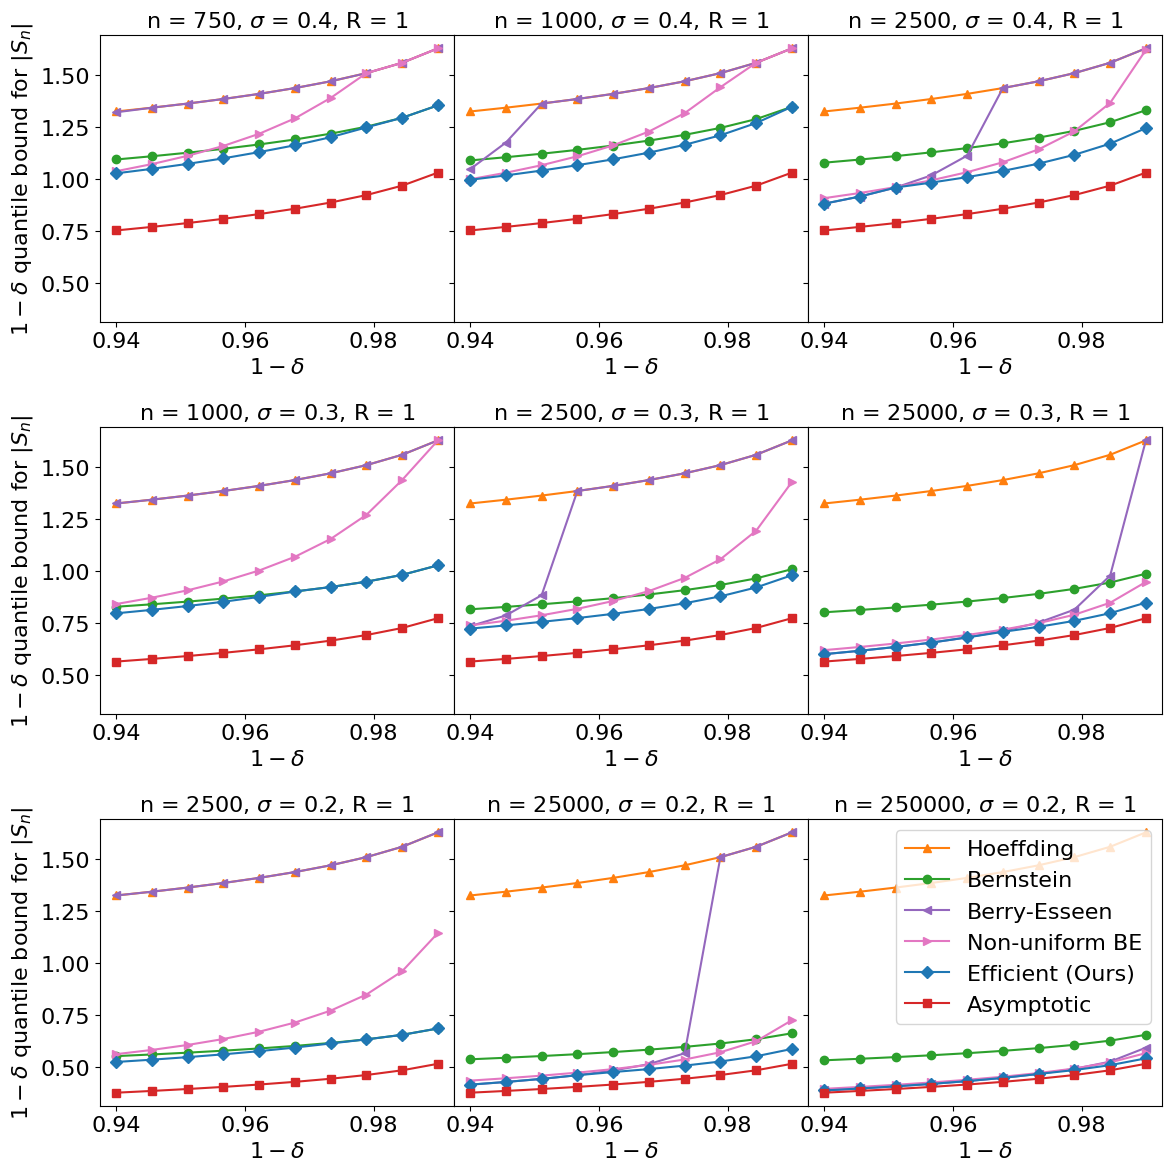

In [ ]:
#%%script false --no-raise-error
# Plot quantile bounds
plt.clf()
R = 1
sigs = R * [.4, .3, .2]
ns = np.vstack((
    np.concatenate(([750, 1000], 25 * (np.power(10, range(2,3))))),
    np.concatenate(([1000], 25 * (np.power(10, range(2,4))))),
    25 * (np.power(10, range(2,5)))
))
deltas = np.linspace(0.01, 0.06, num=10)
two_sided = True
hoeffding = True
verbose = False
quantile_fig = plot_quantile_bounds(deltas, ns, sigs, R, two_sided,
                                    hoeffding=hoeffding, verbose=verbose)

In [ ]:
#%%script false --no-raise-error
# Save quantile bounds figure to file
savefig(quantile_fig,f"quantile_bounds_hoeffding{hoeffding}_twosided{two_sided}.pdf")

## Empirical variance quantile bound

In [ ]:
def emp_quantile_bound(delta, n, p=None, sighat=1, R=1, m3=1, m4=1,
                       two_sided=True, verbose=False, Ws=None):
    """Empirical variance quantile bound for an iid sum

    Returns q s.t. P(|S| > q) <= delta (if two_sided) or P(S > q) <= delta
    (otherwise) for any sum S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i]
    with each independent and identically distributed W_i in [0, R]
    based on the observed statistics sighat.

    Specifically, returns
      sup_{sig in [sig_lower(a), sig_upper(a)]}
        quantile_bound(delta-a, n, p=p, sig=sig, R)
    where sig in [sig_lower(a), sig_upper(a)] with probability at least 1-a,
    and a = delta * asymptotic_quantile(delta,sig=1,two_sided=two_sided)/sqrt_n.

    Args:
      delta - Upper tail probability
      n - Number of datapoints W_i
      p - None (to return minimum bound over all p) or integer Wasserstein
        distance power >= 1
      sighat - Empirical standard deviation;
        sighat = sqrt((1/n)sum_i (W_i - (1/n)sum_i W_i)^2);
        lies in range [0, R/2]
      R - Boundedness parameter
      two_sided - Provide two-sided quantile bound?
      verbose - If True will display minimize_scalar convergence messages
      Ws - If not None, this dictionary (indexed by candidate sig values)
        of dictionaries (indexed by p) will be queried for
        precomputed values before computing any gsn_wass(n, p, sig, R) values;
        if not present, values will be added to this dictionary
    """
    if Ws is None:
        # Initialize empty cache dictionary
        Ws = {}

    # Compute baseline deterministic quantile bound
    hoeff_q = hoeffding_quantile(delta,R,two_sided=two_sided)
    # Compute KS-based quantile
    sqrt_n = sqrt(n)
    c_prime =  (
        R * kstwo.ppf(1-delta/2,n) if two_sided else R * ksone.ppf(1-delta/2,n))
    baseline_bound = min(sqrt_n*c_prime, hoeff_q)

    # Define collection of bounds parameterized by a in (0,delta)
    sighat_sqd = sighat**2
    R_sqd = R**2
    scaled_sighat = sqrt(n/(n-1))*sighat
    def bound(a, verbose=verbose):
        # Returns upper bound on S

        # Bound is only non-vacuous for a in (0,delta)
        if a <= 0 or a >= delta:
            return baseline_bound

        # With probability at least 1-a/2, sup_x |F(x) - Fhat(x)| <= eps
        # for F the CDF of a random variable on [0,1] and Fhat is an empirical
        # CDF based on n iid draws from that distribution.
        # Hence the event E2 = {|(1/n)sum_i(W_i - mu)^2 - sig^2| <= R_sig^2 eps}
        # occurs with probability at least 1-a/2, for mu = E[W_1].
        eps = kstwo.ppf(1-a/2, n)

        # Compute KS lower estimate for sig: on E2,
        # sig^2 >= sig_lower^2
        #   = (R^2-[(R eps + sqrt(R^2 - (1-eps) 4 sighat^2))/(1-eps)]^2)/4
        sig_lower = min(R/2, .5 * sqrt(max(0,
            R_sqd-((R*eps + sqrt(R_sqd-(1-eps)*4*sighat_sqd))/(1-eps))**2)))
        # Compute Maurer-Pontil lower estimate for sig
        # sig >= sqrt(n/(n-1))*sighat - sqrt(2log(2/a)/(n-1))
        mp_offset = sqrt(2*log(2/a)/(n-1))

        # Upper bound on deviation |W_i - mu| when sig^2 >= sig_lower^2
        Rs = deviation_bound(sig_lower, R=R)
        Rs_sqd = Rs**2
        # Compute KS upper estimate for sig
        # sig^2 <= sighat^2 + Rs_sqd * eps + ks_offset^2
        ks_offset = R * eps if two_sided else R * ksone.ppf(1-a/2,n)
        sig_sqd_upper = sighat_sqd +  Rs_sqd * eps + ks_offset**2
        sig_upper = sqrt(sig_sqd_upper)
        # Compute Maurer-Pontil upper estimate for sig
        # sig <= sqrt(n/(n-1))*sighat + sqrt(2log(2/a)/(n-1))
        sig_upper = min(sig_upper, scaled_sighat + mp_offset, R/2)

        if verbose:
            print(f"a={a}: [sig_lower,sig_upper] = [{sig_lower},{sig_upper}]")

        # Maximize quantile_bound(delta-a) over [sig_lower,sig_upper]
        # Terminate optimization early if any bound is worse than alternative
        stop_early = [False]
        def tomin(sig):
            if stop_early[0]:
                return -baseline_bound
            # Reuse any cached gsn_wass results for this candidate
            # sigma value
            if sig not in Ws:
                Ws[sig] = {}
            q_bd = quantile_bound(delta-a,n,p=p,sig=sig,R=R,
                                  two_sided=two_sided, Ws=Ws[sig])
            if q_bd >= baseline_bound:
                stop_early[0] = True
            return -q_bd

        mins=minimize_scalar(tomin, bounds=[sig_lower,sig_upper],
                             method='bounded')
        B_bound=-mins.fun
        return min(B_bound, baseline_bound)


    if False:
        # Plot log bound as a function of k
        a_vals = np.linspace(0, delta)
        plt.plot(a_vals, [log(bound(a,verbose=False)) for a in a_vals])
        plt.ylabel(r'Log bound on $1-\delta$ quantile')
        plt.xlabel(r'$a$')
        plt.title(fr'$\delta$ = {delta}, n = {n}, ' r'$\hat{\sigma}$'
                  f' = {sighat}, R = {R}, m3 = {m3}, m4 = {m4}')
        plt.tight_layout()
        plt.show()

    # Evaluate bound at a_n
    a_n = delta * asymptotic_quantile(delta,sig=1,two_sided=two_sided)/sqrt_n
    tic()
    bound_a_n = bound(a_n, verbose=verbose)
    elapsed = toc()
    if verbose:
        print(f"elapsed: {elapsed}s, a_n={a_n}, bound(a_n)={bound_a_n}\n")
    return  min(bound_a_n, hoeff_q)

## Plot empirical variance quantile bounds

In [ ]:
def rw_sig_est(delta, n, sighat=1, R=1):
    """Returns upper and lower estimates for the standard deviation sig of n
    independent and identically distributed W_i in [0, R]
    based on the empirical variance,
    sighat^2 = (1/n) sum_i (W_i - (1/n) sum_i W_i))^2.

    The estimates (sig_lower, sig_upper) satisfy sig_lower <= sig <= sig_upper
    with probability at least 1-delta and are based on Lemma 4.2 of
    Romano and Wolf - Finite Sample Nonparametric Inference and Large Sample
    Efficiency.
    """
    # Quantile of the Kolmogorov-Smirnov two-sided statistic
    # (without sqrt(n) scaling).
    # That is, quantile of sup_x |F(x) - Fhat(x)|
    # for F the CDF of a random variable on [0,1] and Fhat is an empirical CDF
    # based on n iid draws from that distribution
    c_n = kstwo.ppf(1-delta, n)
    offset = 3 * c_n
    # Derive Romano-Wolf-based upper and lower estimates by
    # considering variables W' = W/R in [0,1]
    # with sig(W') = sig(W)/R and then rescaling overall bound by R
    sighat_over_R_sqd = ((sighat / R) ** 2)
    sig_upper = R * min(.5, sqrt(sighat_over_R_sqd  + offset))
    sig_lower = R * sqrt( max(0, sighat_over_R_sqd - offset) )
    return (sig_lower, sig_upper)

def plot_emp_quantile_bounds(deltas, ns, sighats, R, two_sided=True,
                             verbose=False, bounds=['hoeff','eff','rw','bern'],
                             recompute=False):
    """Displays and returns a len(sigs) by ns.shape[1] matrix of quantile bound
    plots

    For each sample size, empirical standard deviation pair
    (n,sig)=(ns[ii,jj],sigs[ii]), plots empirical quantile bounds q(delta)
    satisfying P(|S| >= q(delta)) <= delta for each quantile probability delta
    in deltas.
    Here S = sqrt(n) (1/n) sum_{i=1}^n W_i - E[W_i] represents any sum
    with each independent and identically distributed W_i in [0, R], empirical
    variance sighat^2, empirical centered third moment dictated by m3_mult,
    and empirical variance of (W_i - sighat^2) dictated by m4_mult.

    Args:
      deltas - Iterable (e.g., list or array) of quantile probabilities delta
      ns - Iterable (e.g., list or array) of sample sizes
      sighats - Iterable (e.g., list or array) empirical standard deviations
        (sighat^2 = (1/n)sum_i (W_i - (1/n)sum_i W_i)^2)
      R - Boundedness parameters
      two_sided - Plot two-sided quantile bounds?
      verbose - Verbosity parameter for emp_quantile_bound function
      bounds - List of optional bounds to plot; valid values are
        'hoeff' for Hoeffding, 'rw' for Romano-Wolf, 'eff' for efficient,
        'bern' for Bernstein
      recompute - If False, attempt to load previously saved 'eff' bounds
        from disk; otherwise, recompute 'eff' bounds

    Returns: Plotted figure
    """

    # Display matrix of plots with one row for each value of R and one column for each
    # value of n
    plt.rcParams['font.size'] = '16'
    num_rows = len(sighats)
    num_cols = ns.shape[1]
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols,
                           sharey=True,
                           figsize=(num_cols*4,num_rows*4))
    # Create directory for results
    results_dir = "results"
    os.makedirs(results_dir, exist_ok=True)
    for ii in range(num_rows):
        sighat = sighats[ii]
        for jj in range(num_cols):
            n = ns[ii,jj]
            sqrt_n = sqrt(n)
            print(f"plotting n={n},sighat={sighat}")
            tic()
            def romano_wolf_quantile(delta):
                # Romano-Wolf-based upper and lower estimates for sigma
                b_n = delta * asymptotic_quantile(
                    delta,sig=1,two_sided=two_sided)/sqrt_n
                sig_lower, sig_upper = rw_sig_est(b_n, n, sighat=sighat, R=R)
                if sig_lower <= 0:
                    bound_val = np.inf
                else:
                    # Evaluate Berry Esseen bound as if sig_lower was true sigma
                    q_a = berry_esseen_quantile_rw(delta-b_n, n, sig=sig_lower,
                                                   R=R, two_sided=two_sided)
                    # Rescale quantile bound appropriately
                    bound_val = q_a * sig_upper / sig_lower
                # Compare with Hoeffding quantile
                return min(bound_val,
                           hoeffding_quantile(delta, R=R, two_sided=two_sided))

            # Dictionary to Wasserstein distance results across delta values
            Ws = {}
            def emp_quantile(delta):
                # Check whether previously computed value is available on disk
                filename = os.path.join(
                    results_dir,
                    f"delta{delta}-n{n}-sig{sighat}-two{two_sided}.pkl")

                if (not recompute) and os.path.isfile(filename):
                    with open(filename, "rb") as f:
                        return pickle.load(f)
                else:
                    q = emp_quantile_bound(delta, n, sighat=sighat, R=R,
                                           two_sided=two_sided,
                                           verbose=verbose, Ws = Ws)

                    # Save result to disk
                    with open(filename, "wb") as f:
                        pickle.dump(q, f, protocol=pickle.HIGHEST_PROTOCOL)
                    return q

            if num_rows > 1 and num_cols > 1:
                subplt = ax[ii,jj]
            elif num_rows == 1 and num_cols == 1:
                subplt = ax
            elif num_rows > 1:
                subplt = ax[ii]
            else:
                subplt = ax[jj]
            one_minus_deltas = [1-delta for delta in deltas]

            if 'hoeff' in bounds:
                subplt.plot(one_minus_deltas, [(hoeffding_quantile(delta,R=R,two_sided=two_sided)) for delta in deltas],
                            label = "Hoeffding",
                            #linestyle='dotted',
                            color='tab:orange',
                            marker='^')
            if 'bern' in bounds:
                subplt.plot(one_minus_deltas, [(emp_bernstein_quantile(delta,n,sighat=sighat,R=R,two_sided=two_sided)) for delta in deltas],
                            label = "Empirical Bernstein",
                            #linestyle='dotted',
                            color='tab:green',
                            marker='o')
            if 'rw' in bounds:
                subplt.plot(one_minus_deltas, [(romano_wolf_quantile(delta)) for delta in deltas],
                            label = "Romano-Wolf",
                            #linestyle='dashed',
                            color='tab:purple',
                            marker='v')
            if 'eff' in bounds:
                subplt.plot(one_minus_deltas, [(emp_quantile(delta)) for delta in deltas],
                            label = r"Empirical Berry-Esseen (Ours)",
                            #linestyle='dashed',
                            color='tab:blue',
                            marker='D')

            subplt.plot(one_minus_deltas, [(asymptotic_quantile(delta,sig=sighat,two_sided=two_sided)) for delta in deltas],
                        label = "Empirical Asymptotic",
                        #linestyle='solid',
                        #linestyle='dashed',
                        color='tab:red',
                        marker='s', alpha=.7, linewidth=2)

            if jj == 0:
                if two_sided:
                    subplt.set_ylabel(r'$1-\delta$ quantile bound for $|S_n|$',fontsize=16)
                else:
                    subplt.set_ylabel(r'$1-\delta$ quantile bound for $S_n$',fontsize=16)
            subplt.set_xlabel(r'$1-\delta$',fontsize=16)
            subplt.set_title(fr'n = {n}, ' r'$\hat{\sigma}$' f' = {sighat}, R = {R}',fontsize=16)
            if jj == num_cols-1 and ii == num_rows-1:
                subplt.legend()#loc='center right')
            print(f"elasped: {toc()}s")

    fig.tight_layout()
    plt.subplots_adjust(wspace=0)
    plt.show()
    return fig

plotting n=750,sighat=0.4
elasped: 267.83490943200013s
plotting n=1000,sighat=0.4
elasped: 265.96250028600025s
plotting n=2500,sighat=0.4
elasped: 289.3223502230003s
plotting n=1000,sighat=0.3
elasped: 269.23773270200036s
plotting n=2500,sighat=0.3
elasped: 285.9704370220006s
plotting n=25000,sighat=0.3
elasped: 354.54188344199974s
plotting n=2500,sighat=0.2
elasped: 284.04584113500005s
plotting n=25000,sighat=0.2
elasped: 332.76594081999974s
plotting n=250000,sighat=0.2
elasped: 909.1476389119998s


<Figure size 640x480 with 0 Axes>

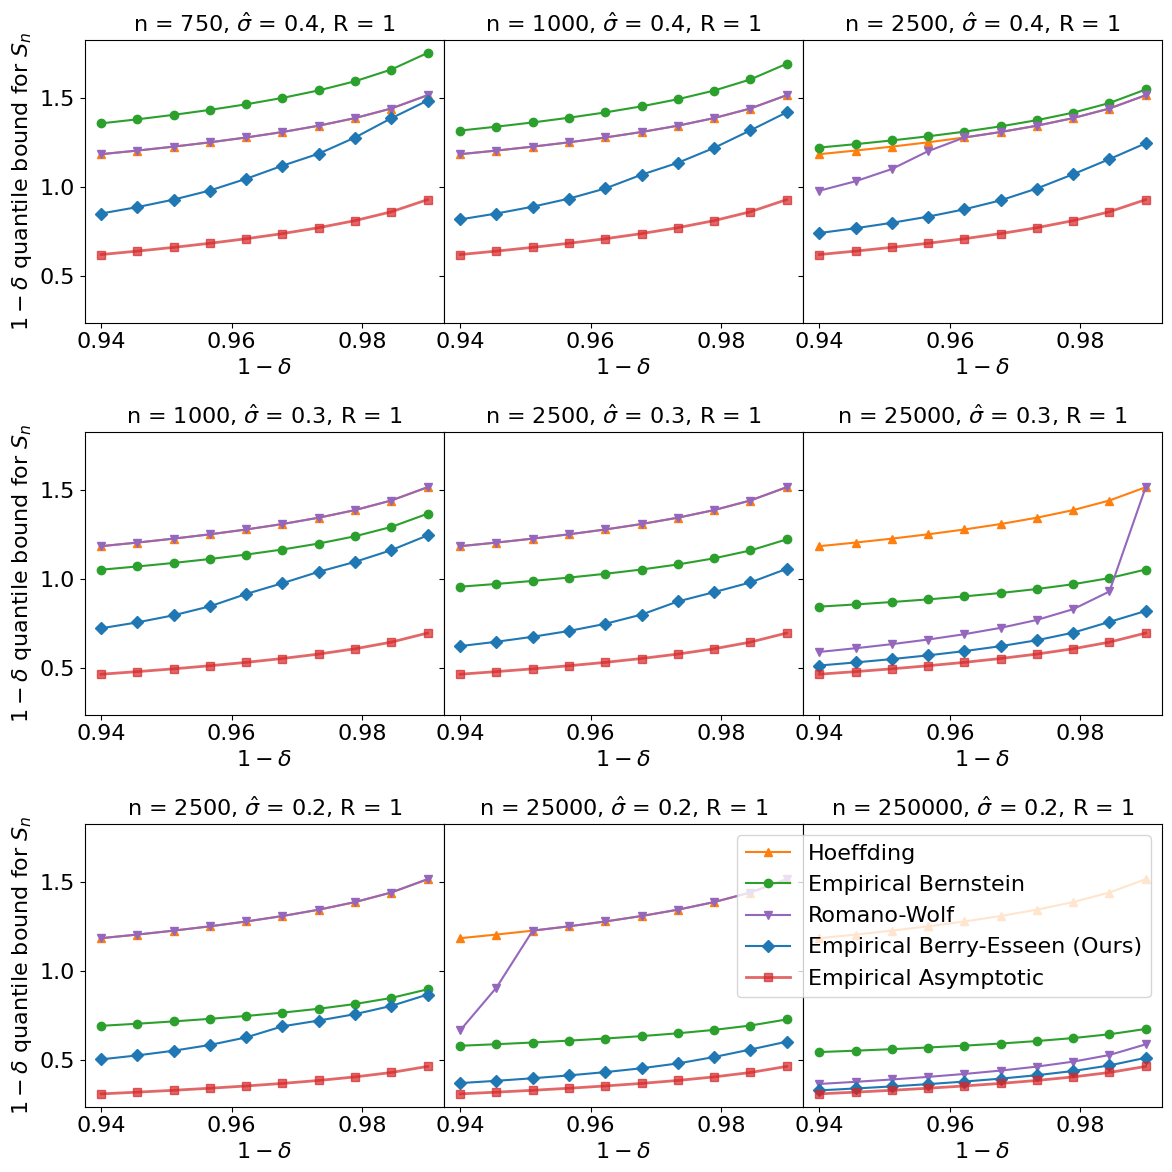

In [ ]:
#%%script false --no-raise-error
# Plot empirical quantile bounds
plt.clf()
R = 1
# Lies in range [0, R/2]
sighats = R * [.4, .3, .2]
ns = np.vstack((
    np.concatenate(([750, 1000], 25 * (np.power(10, range(2,3))))),
    np.concatenate(([1000], 25 * (np.power(10, range(2,4))))),
    25 * (np.power(10, range(2,5)))
))
deltas = np.linspace(0.01, 0.06, num=10)
verbose = False
bounds=['rw','hoeff','eff','bern']
two_sided = False
recompute = False
emp_quantile_fig = plot_emp_quantile_bounds(
    deltas, ns, sighats, R, two_sided=two_sided,
    verbose=verbose, bounds=bounds, recompute=recompute)

In [ ]:
#%%script false --no-raise-error
# Save empirical quantile bounds figure to file
savefig(emp_quantile_fig,f"emp_quantile_bounds_twosided{two_sided}.pdf")

## Early stopping rules

In [ ]:
#
# Implementations of Hoeffding stopping, empirical Bernstein stopping (EBA Geo),
# and empirical Berry-Esseen stopping (EBE Geo)
#

# t_min based on Höffding's bound
# Source: https://github.com/UgurTepe/EmpiricalBernsteinAlgorithm
def hoeffding_bound(delta, epsilon, rng):
    return 0.5*np.log(2/delta)*rng**2/epsilon**2

# Welford method to get the running standard deviation and the running mean
# Source: https://github.com/UgurTepe/EmpiricalBernsteinAlgorithm
class Welford():
    """
    Class for calculating the mean and standard deviation using the Welford's method.

    Attributes:
        n (int): The number of data points.
        M (float): The current mean.
        S (float): The current sum of squared differences from the mean.

    Methods:
        update(x): Updates the mean and sum of squared differences with a new data point.
        mean: Returns the current mean.
        std: Returns the current standard deviation.
    """

    def __init__(self, a_list=None):
        self.n = 0
        self.M = 0
        self.S = 0

    def update(self, x):
        """
        Updates the mean and sum of squared differences with a new data point.

        Args:
            x (float): The new data point.

        Returns:
            None
        """
        self.n += 1
        newM = self.M + (x - self.M) / self.n
        newS = self.S + (x - self.M) * (x - newM)
        self.M = newM
        self.S = newS

    @property
    def mean(self):
        """
        Returns the current mean.

        Returns:
            float: The current mean.
        """
        return self.M

    @property
    def std(self):
        """
        Returns the current standard deviation.

        Returns:
            float: The current standard deviation.
        """
        if self.n == 1:
            return 0
        return np.sqrt(self.S / (self.n - 1))

# Modified slightly from https://github.com/UgurTepe/EmpiricalBernsteinAlgorithm
# to repair an off-by-one error in the current_t counter
class eba_geo():
    """
    Empirical Bernstein Algorithm (EBA) for geometrically decreasing step sizes.

    Parameters:
    - delta (float): The confidence parameter. Default is 0.1.
    - epsilon (float): Accuracy threshold. Default is 0.1.
    - range_of_rndvar (float): The range of the random variable. Default is 1.
    - beta (float): The geometric decay factor. Default is 1.1.

    Attributes:
    - delta (float): The confidence parameter.
    - epsilon (float): Accuracy threshold.
    - range_of_rndvar (float): The range of the random variable.
    - samples (list): List of samples.
    - running_mean (list): List of running means.
    - sample_sum (float): Sum of all samples.
    - running_variance (list): List of running variances.
    - ct (list): List of c_t values.
    - p (float): The power parameter.
    - beta (float): The geometric decay factor.
    - current_k (int): Current value of k.
    - current_t (int): Current value of t.
    - cons (float): Constant value used in c_t calculation.
    - welf (Welford): Welford object for calculating running variance.

    Methods:
    - add_sample(sample): Adds a sample to the algorithm and updates the parameters.
    - cond_check(): Checks if the EBA algorithm should stop.
    - inner_cond_check(): Checks if the inner loop condition is satisfied.
    - calc_ct(): Calculates the value of c_t for a given time t.
    - update_ct(): Updates the value of c_t.
    - get_ct(): Returns the array of c_t values.
    - get_estimate(): Returns the latest estimated mean.
    - get_mean(): Returns the array of estimated means.
    - get_var(): Returns the array of variances.
    - get_step(): Returns the current iteration/step.
    """

    def __init__(self, delta=0.1, epsilon=0.1, range_of_rndvar=1, beta=1.1):
        """
        Initialize the EBA algorithm with the given parameters.

        Parameters:
        - delta (float): The confidence parameter. Default is 0.1.
        - epsilon (float): Accuracy threshold. Default is 0.1.
        - range_of_rndvar (float): The range of the random variable. Default is 1.
        - beta (float): The geometric decay factor. Default is 1.1.
        """
        self.delta = delta
        self.epsilon = epsilon
        self.range_of_rndvar = range_of_rndvar
        self.samples = []
        self.running_mean = [0]
        self.sample_sum = 0
        self.running_variance = [0]
        self.ct = []
        self.p = 1.1
        self.beta = beta
        self.current_k = 0
        self.current_t = 0 ###
        self.cons = 3/((delta*(self.p-1))/self.p)
        self.welf = Welford()

    def add_sample(self, sample):
        """
        Add a sample to the algorithm and update the parameters.

        Parameters:
        - sample: The sample to be added.
        """


        # Insert new sample
        self.samples.append(sample)

        # cummulative sum
        self.sample_sum += sample

        ###
        # Update current step
        self.current_t = self.current_t + 1
        ###

        # Calculates the running mean efficiently with sample_sum
        cur_mean = np.divide(self.sample_sum, self.current_t)
        self.running_mean.append(cur_mean)

        # Running variance
        self.welf.update(sample)
        self.running_variance.append(np.square(self.welf.std))

    def cond_check(self):
        """
        Check if the EBA algorithm should stop.

        Returns:
        - bool: True if the algorithm should continue, False otherwise.
        """
        if self.current_k == 0:
            return True
        if self.ct[-1] > self.epsilon:
            return True
        else:
            return False

    def inner_cond_check(self):
        """
        Check if the inner loop condition is satisfied.

        Returns:
        - none
        updates ct if the condition is satisfied
        """
        if self.current_t > np.floor(self.beta**self.current_k):
            self.update_ct()

    def calc_ct(self):
        """
        Calculate the value of c_t for a given time t.

        Returns:
        - float: The value of c_t.
        """
        ln_constant = np.log(self.cons, dtype=np.float64)/self.current_t
        ln_vari = self.p*np.log(self.current_k,
                                dtype=np.float64)/self.current_t
        ln_compl = (ln_constant+ln_vari)
        result = (
            np.sqrt(2*self.running_variance[-1]*ln_compl) + (3*self.range_of_rndvar*ln_compl))
        return result

    def update_ct(self):
        """
        Update the value of c_t.
        """
        # Update ct
        self.current_k += 1
        self.ct.append(self.calc_ct())

    def get_ct(self):
        """
        Get the array of c_t values.

        Returns:
        - ndarray: Array of c_t values.
        """
        return np.asarray(self.ct)

    def get_estimate(self):
        """
        Get the latest estimated mean.

        Returns:
        - float: The latest estimated mean.
        """
        return self.running_mean[-1]

    def get_mean(self):
        """
        Get the array of estimated means.

        Returns:
        - ndarray: Array of estimated means.
        """
        return np.asarray(self.running_mean)

    def get_var(self):
        """
        Get the array of variances.

        Returns:
        - ndarray: Array of variances.
        """
        return np.asarray(self.running_variance)

    def get_step(self):
        """
        Get the current iteration/step.

        Returns:
        - int: The current iteration/step.
        """
        return self.current_t

# Based on eba_geo of https://github.com/UgurTepe/EmpiricalBernsteinAlgorithm
class ebe_geo():
    """
    Empirical Berry Esseen (EBE) for geometrically decreasing step sizes.

    Parameters:
    - delta (float): The confidence parameter. Default is 0.1.
    - epsilon (float): Accuracy threshold. Default is 0.1.
    - range_of_rndvar (float): The range of the random variable. Default is 1.
    - beta (float): The geometric decay factor. Default is 1.1.

    Attributes:
    - delta (float): The confidence parameter.
    - epsilon (float): Accuracy threshold.
    - range_of_rndvar (float): The range of the random variable.
    - samples (list): List of samples.
    - running_mean (list): List of running means.
    - sample_sum (float): Sum of all samples.
    - running_variance (list): List of running variances.
    - ct (list): List of c_t values.
    - p (float): The power parameter.
    - beta (float): The geometric decay factor.
    - current_k (int): Current value of k.
    - current_t (int): Current value of t.
    - cons (float): Constant value used in c_t calculation.
    - welf (Welford): Welford object for calculating running variance.

    Methods:
    - add_sample(sample): Adds a sample to the algorithm and updates the parameters.
    - cond_check(): Checks if the EBA algorithm should stop.
    - inner_cond_check(): Checks if the inner loop condition is satisfied.
    - calc_ct(): Calculates the value of c_t for a given time t.
    - update_ct(): Updates the value of c_t.
    - get_ct(): Returns the array of c_t values.
    - get_estimate(): Returns the latest estimated mean.
    - get_mean(): Returns the array of estimated means.
    - get_var(): Returns the array of variances.
    - get_step(): Returns the current iteration/step.
    """

    def __init__(self, delta=0.1, epsilon=0.1, range_of_rndvar=1, beta=1.1):
        """
        Initialize the EBE algorithm with the given parameters.

        Parameters:
        - delta (float): The confidence parameter. Default is 0.1.
        - epsilon (float): Accuracy threshold. Default is 0.1.
        - range_of_rndvar (float): The range of the random variable. Default is 1.
        - beta (float): The geometric decay factor. Default is 1.1.
        """
        self.delta = delta
        self.epsilon = epsilon
        self.range_of_rndvar = range_of_rndvar
        self.samples = []
        self.running_mean = [0]
        self.sample_sum = 0
        self.running_variance = [0]
        self.ct = []
        self.p = 1.1
        self.beta = beta
        self.current_k = 0
        self.current_t = 0 ###
        self.welf = Welford()

    def add_sample(self, sample):
        """
        Add a sample to the algorithm and update the parameters.

        Parameters:
        - sample: The sample to be added.
        """

        # Insert new sample
        self.samples.append(sample)

        # cummulative sum
        self.sample_sum += sample

        ###
        # Update current step
        self.current_t = self.current_t + 1
        ###

        # Calculates the running mean efficiently with sample_sum
        cur_mean = np.divide(self.sample_sum, self.current_t)
        self.running_mean.append(cur_mean)

        # Running variance
        self.welf.update(sample)
        self.running_variance.append(np.square(self.welf.std))


    def cond_check(self):
        """
        Check if the EBA algorithm should stop.

        Returns:
        - bool: True if the algorithm should continue, False otherwise.
        """
        if self.current_k == 0:
            return True
        if self.ct[-1] > self.epsilon:
            return True
        else:
            return False

    def inner_cond_check(self):
        """
        Check if the inner loop condition is satisfied.

        Returns:
        - none
        updates ct if the condition is satisfied
        """
        if self.current_t > np.floor(self.beta**self.current_k):
            self.update_ct()

    def calc_ct(self):
        """
        Calculate the value of c_t for a given time t.

        Returns:
        - float: The value of c_t.
        """
        # Confidence level 1-d for d = delta * (p-1)/(p * k^p)
        d = self.delta * (self.p - 1) / self.p / (self.current_k ** self.p)
        tic()
        result = emp_quantile_bound(
            d, self.current_t, sighat=sqrt(self.running_variance[-1]),
            R=self.range_of_rndvar, two_sided=True)/sqrt(self.current_t)
        h_result = hoeffding_quantile(d,R=self.range_of_rndvar, two_sided=True)/sqrt(self.current_t)
        print(f"ebe (k={self.current_k},t={self.current_t},c_t={result},hoeffc_t={h_result}), elapsed: {toc()}")
        return result

    def update_ct(self):
        """
        Update the value of c_t.
        """
        # Update ct
        self.current_k += 1
        self.ct.append(self.calc_ct())

    def get_ct(self):
        """
        Get the array of c_t values.

        Returns:
        - ndarray: Array of c_t values.
        """
        return np.asarray(self.ct)

    def get_estimate(self):
        """
        Get the latest estimated mean.

        Returns:
        - float: The latest estimated mean.
        """
        return self.running_mean[-1]

    def get_mean(self):
        """
        Get the array of estimated means.

        Returns:
        - ndarray: Array of estimated means.
        """
        return np.asarray(self.running_mean)

    def get_var(self):
        """
        Get the array of variances.

        Returns:
        - ndarray: Array of variances.
        """
        return np.asarray(self.running_variance)

    def get_step(self):
        """
        Get the current iteration/step.

        Returns:
        - int: The current iteration/step.
        """
        return self.current_t

## Run early stopping experiment

In [ ]:
def early_stopping(method, l, seed=None, recompute=False):
    """Runs an early stopping experiment with each observation
    equal to the average of l independent Uniform([0,1]) random variables

    Args:
      method - "eff" for efficient empirical Berry Esseen (ebe_geo) or
        "bern" for empirical Bernstein (eba_geo)
      l - number of uniforms averaged together in each observation
      seed - random number generator initialization
      recompute - if False, will avoid recomputing "eff" result if result
        has been previously saved to disk

    Returns: number of steps taken before stopping

    Side effects: saves "eff" result to disk
    """
    if method == "eff":
        result_file = os.path.join(stop_dir, f"ebe_steps-l{l}-seed{seed}.h5")
        if not recompute:
            # If result file already exists, load from disk
            if os.path.isfile(result_file):
                return pd.read_hdf(result_file).squeeze()
        constructor = ebe_geo
    elif method == "bern":
        constructor = eba_geo
    else:
        raise ValueError(f"Unknown method {method}")

    rng = np.random.default_rng(seed)
    rule = constructor(epsilon=eps,delta=delta,range_of_rndvar=R)
    # Stops when condition is met
    while rule.cond_check():
        # Get random variable that is uniformly dist.
        sample = rng.uniform(a,b,(1,l))
        sample = np.mean(sample,axis=1)[0]
        rule.add_sample(sample)
        # Update confidence bounds on appropriate schedule
        rule.inner_cond_check()
    steps = rule.get_step()

    if method == "eff":
        # Save result to disk
        df = pd.DataFrame([steps])
        df.to_hdf(result_file, key="data")
    return steps

In [ ]:
#
# Run early stopping experiment
#

# Directory for results
stop_dir = "stop_results"
os.makedirs(stop_dir,exist_ok=True)

seeds = [12345 + i for i in range(10)]
a = 0
b = 1
eps = 0.01
delta = 0.1
R = b - a
# Number of uniforms l to average together to form observations
l_arr = [5,10,50,100,1000]
#l_arr = [1000,100,50,10,5]

# For each random seed and parameter l, run early stopping experiment with
# EBAGeo (empirical Bernstein), EBEGeo (empirical Berry-Esseen),
# and Hoeffding and store results in a dataframe.
methods = ["hoeff","bern","eff"]
hoeff_n = int(ceil(hoeffding_bound(delta = delta, epsilon=eps,rng=R)))
results = pd.DataFrame(columns=["seed","l","method","n"])
for seed in seeds:
    eba_geo_arr = []
    ebe_arr = []
    for l in l_arr:
        print(f"seed={seed},l={l}"); tic()
        for method in methods:
            if method == "hoeff":
                n = hoeff_n
            else:
                n = early_stopping(method, l, seed=seed)
            results.loc[len(results)] = [seed,l,method,n]
        print(f"elapsed: {toc()}")

seed=12345,l=5
elapsed: 1.9689533689999905
seed=12345,l=10
elapsed: 0.8738461170000136
seed=12345,l=50
elapsed: 1.1048352460000075
seed=12345,l=100
elapsed: 0.7093205640000093
seed=12345,l=1000
elapsed: 0.5481145540000085
seed=12346,l=5
elapsed: 1.1452300730000076
seed=12346,l=10
elapsed: 0.9073854289999872
seed=12346,l=50
elapsed: 0.5914558859999914
seed=12346,l=100
elapsed: 0.6686860549999949
seed=12346,l=1000
elapsed: 0.6873303790000023
seed=12347,l=5
elapsed: 1.009324410000005
seed=12347,l=10
elapsed: 0.732977340000005
seed=12347,l=50
elapsed: 0.7205979439999908
seed=12347,l=100
elapsed: 0.606960887999989
seed=12347,l=1000
elapsed: 0.7335597630000024
seed=12348,l=5
elapsed: 1.8722125860000034
seed=12348,l=10
elapsed: 1.0482927529999984
seed=12348,l=50
elapsed: 1.012497897000003
seed=12348,l=100
elapsed: 1.1189052590000017
seed=12348,l=1000
elapsed: 1.2592186839999897
seed=12349,l=5
elapsed: 1.2918885750000015
seed=12349,l=10
elapsed: 0.7473623309999908
seed=12349,l=50
elapsed: 0.71

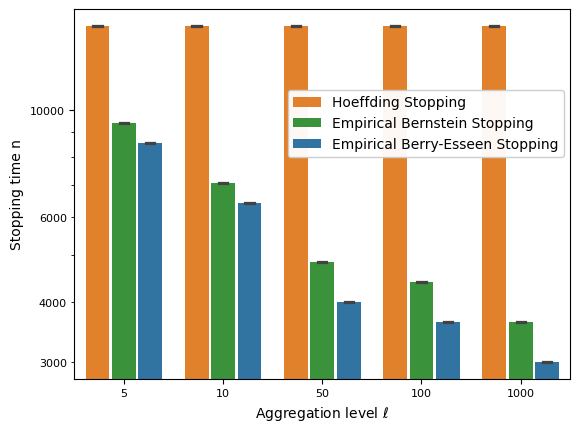

In [ ]:
#
# Plot results
#
from matplotlib.ticker import LogFormatter
fontsize=10
plt.rcParams['font.size'] = f'{fontsize}'
plt.clf()
palette = sns.color_palette()
ax = sns.barplot(results, x="l", y="n", hue="method", dodge=True, gap=.1,
                 palette=[palette[1],palette[2],palette[0]],capsize=.25,
                 errorbar=("pi",95))
ax.set_yscale("log")
ax.yaxis.set_major_formatter(LogFormatter())
ax.yaxis.set_minor_formatter(LogFormatter())
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc=(.43,.6), framealpha=0.95,
          labels=["Hoeffding Stopping",
                  "Empirical Bernstein Stopping",
                  "Empirical Berry-Esseen Stopping"])
plt.xlabel("Aggregation level $\ell$",fontsize=fontsize)
plt.ylabel("Stopping time n",fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
fig = plt.gcf()
plt.show()

# Save early stopping figure to file
savefig(fig, f"stop-delta{delta}-eps{eps}.pdf")